In [1]:
import argparse
import os
import random
import time
from distutils.util import strtobool
from collections import namedtuple

import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from stable_baselines3.common.atari_wrappers import (
    ClipRewardEnv,
    EpisodicLifeEnv,
    FireResetEnv,
    MaxAndSkipEnv,
    NoopResetEnv,
)
from torchsummary import summary
from stable_baselines3.common.buffers import ReplayBuffer
from torch.utils.tensorboard import SummaryWriter
from einops.layers.torch import Rearrange
from torchvision.transforms import Resize, InterpolationMode


pygame 2.1.3 (SDL 2.0.22, Python 3.7.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:

def parse_args():
    
    class Args:
        
        def __init__(self):
            pass
        
    args_dict = dict(batch_size=64,
              buffer_size=1000000,
              capture_video=False,
              capture_video_frequency=50,
              cuda=True, end_e=0.02,
              env_id='Taxi-v3',
              eta = 0.1,
              exp_name='ICM_taxi',
              exploration_fraction=0.2,
              gamma=0.99, hf_entity='',
              learning_rate=0.0001,
              learning_starts=80000,
              num_envs=1,
              save_model=True,
              seed=1,
              start_e=1,
              target_network_frequency=5000,
              tau=1.0,
              torch_deterministic=True,
              total_timesteps=5000000,
              track=False, train_frequency=4,
              upload_model=False,
              wandb_entity=None, 
              wandb_project_name='cleanRL')
    args = Args()
    args.__dict__ = args_dict
    
    return args


In [3]:

def make_env(env_id, seed, idx, capture_video, run_name, capture_video_frequency):
    def thunk():
        if capture_video and idx == 0:
            env = gym.make(env_id, render_mode="rgb_array")
            env = gym.wrappers.RecordVideo(env, f"videos/{run_name}", episode_trigger = lambda x: x % capture_video_frequency == 0)
        else:
            env = gym.make(env_id, render_mode="rgb_array")
        env = gym.wrappers.RecordEpisodeStatistics(env)
        #env = NoopResetEnv(env, noop_max=30)
        #env = MaxAndSkipEnv(env, skip=4)
        #env = EpisodicLifeEnv(env)
        #if "FIRE" in env.unwrapped.get_action_meanings():
        #    env = FireResetEnv(env)
        #env = ClipRewardEnv(env)
        #env = gym.wrappers.ResizeObservation(env, (84, 84))
        #env = gym.wrappers.GrayScaleObservation(env)
        #env = gym.wrappers.FrameStack(env, 4)
        env.action_space.seed(seed)

        return env

    return thunk


def to_tensor(x, dtype=torch.float32):
    try:
        x=torch.tensor(x, dtype=dtype).to(device)
    except:
        x=torch.Tensor(x, dtype=dtype).to(device)
    
    return x

downscale = Resize(size = (70, 110), interpolation = InterpolationMode.NEAREST)

def get_image(envs):    
    s_im=envs.call('render')[0].transpose(2,0,1)
    s_im=downscale(torch.Tensor(s_im))/255
    s_im=np.expand_dims(s_im, 0)
    
    return to_tensor(s_im)


In [4]:

class DeepSR_ICM(nn.Module):
    def __init__(self,
                 env,
                 hidden_dim = 256):
        super().__init__()
        self.n_actions = env.single_action_space.n
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 7, stride=5),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 5, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride=1),
            nn.ReLU(),
            Rearrange('b c h w -> b (c h w)'),
            nn.Linear(1344, hidden_dim),
#            nn.ReLU(),
#            nn.Linear(512, 512),
        )
        
        self.feed_forward = nn.Sequential(
            nn.Linear(hidden_dim + self.n_actions, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, hidden_dim),
        )
        
        self.inverse_model = nn.Sequential(
            nn.Linear(hidden_dim * 2, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, self.n_actions),
            nn.Softmax(dim = 1)
        )
        
        self.reward_estimate = nn.Linear(hidden_dim, 1, bias = False)
        self.w = self.reward_estimate.weight
        self.sr_encoder = nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim // 2),
                nn.ReLU(),
                nn.Linear(hidden_dim // 2 , hidden_dim // 2),
                nn.ReLU(),
                nn.Linear(hidden_dim // 2, hidden_dim * self.n_actions),
                Rearrange('b (h a) -> b h a', h = hidden_dim,  a = self.n_actions),
            )
        
        self.train_output = namedtuple("TrainingOutput",
                  ("hidden_state",
                   "hidden_next_state",
                   "hidden_next_state_predicted",
                   "action",
                   "action_predicted",
                   "r_estimation",
                   "r_intrinsic",
                   "m",
                   "Q"))
        self.prediction_output = namedtuple("PredictionOutput",
                  ("hidden_state",
                   "hidden_next_state_predicted",
                   "action",
                   "action_predicted",
                   "r_estimation",
                   "m",
                   "Q"))
    
    def forward(self, *args, Q_only = False):
        '''
        Input: if training : x (current state), x_n (next state)
               if eval: x (current state)
               
        Output: if training : hidden_state, hidden_next_state, hidden_next_state_predicted,
                              action, action_predicted,
                              r_estimation, r_intrinsic, 
                              m, Q
                if eval: hidden_state, hidden_next_state_predicted,
                         action, action_predicted,
                         r_estimation,
                         m, Q
        '''
        if self.training:
            if len(args) != 3:
                raise Exception("In training phase model takes three arguments - current state, action,  next state.")
            x = args[0]
            action = args[1]
            x_n = args[2]
            
            hidden = self.encoder(x / 255.0)
            hidden_n = self.encoder(x_n / 255.0).detach()
            r = self.reward_estimate(hidden)
            m = self.sr_encoder(hidden.detach())
            Q = (m * self.w.unsqueeze(2)).sum(1)
            
            if not Q_only: 
                action = F.one_hot(action, num_classes = self.n_actions).squeeze(1) * 1.0
                action_pred = self.inverse_model(torch.concat([hidden, hidden_n], 1))
                hidden_n_pred = self.feed_forward(torch.concat([hidden, action], 1))
                r_intrinsic = F.mse_loss(hidden_n_pred, hidden_n, reduction="none").sum(1, keepdim=True)
                
            else:
                action, action_pred, hidden_n_pred, r_intrinsic = None, None, None, None

            return self.train_output(hidden, hidden_n, hidden_n_pred, 
                                     action, action_pred, 
                                     r, r_intrinsic, 
                                     m, Q)
        else:
            if len(args) != 1:
                   raise Exception("In prediction phase model takes one argument - current state.")
            x = args[0]
            hidden = self.encoder(x / 255.0)
            r = self.reward_estimate(hidden)
            m = self.sr_encoder(hidden.detach())
            Q = (m * self.w.unsqueeze(2)).sum(1)
            
            if not Q_only: 
                action = F.one_hot(torch.argmax(Q, dim=1), num_classes = self.n_actions)
                hidden_n_pred = self.feed_forward(torch.concat([hidden, action], 1))
                action_pred = self.inverse_model(torch.concat([hidden, hidden_n_pred], 1))
                
            else:
                action, hidden_n_pred, action_pred  = None, None, None
            
            return self.prediction_output(hidden, hidden_n_pred, 
                                       action, action_pred, 
                                       r,
                                       m, Q)
        
class SREncoder(nn.Module):
    
    def __init__(self,
                 env,
                 hidden_dim = 256):
        super().__init__()
        self.n_actions = env.single_action_space.n
        self.sr_encoder = nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim // 2),
                nn.ReLU(),
                nn.Linear(hidden_dim // 2 , hidden_dim // 2),
                nn.ReLU(),
                nn.Linear(hidden_dim // 2, hidden_dim * self.n_actions),
                Rearrange('b (h a) -> b h a', h = hidden_dim,  a = self.n_actions),
            )
    
    def forward(self, hidden):
        m = self.sr_encoder(hidden.detach())
        return m
    

def exponential_schedule(start_e: float, end_e: float, duration: int, t: int):
    return max(start_e * (0.999997698) ** t, end_e)



In [5]:



if __name__ == "__main__":
    import stable_baselines3 as sb3

    if sb3.__version__ < "2.0":
        raise ValueError(
            """Ongoing migration: run the following command to install the new dependencies:

poetry run pip install "stable_baselines3==2.0.0a1" "gymnasium[atari,accept-rom-license]==0.28.1"  "ale-py==0.8.1" 
"""
        )
    args = parse_args()
    run_name = f"{args.env_id}__{args.exp_name}__{args.seed}__{int(time.time())}"

    writer = SummaryWriter(f"runs/{run_name}")
    writer.add_text(
        "hyperparameters",
        "|param|value|\n|-|-|\n%s" % ("\n".join([f"|{key}|{value}|" for key, value in vars(args).items()])),
    )

    # TRY NOT TO MODIFY: seeding
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    torch.backends.cudnn.deterministic = args.torch_deterministic

    device = torch.device("cuda" if torch.cuda.is_available() and args.cuda else "cpu")
    
    dict_of_observations={}

    # env setup
    envs = gym.vector.SyncVectorEnv(
        [make_env(args.env_id, args.seed + i, i, args.capture_video, run_name,  args.capture_video_frequency) for i in range(args.num_envs)]
    )
    assert isinstance(envs.single_action_space, gym.spaces.Discrete), "only discrete action space is supported"

    sr_network = DeepSR_ICM(envs).to(device)
    optimizer = optim.AdamW(sr_network.parameters(), lr=args.learning_rate)
    target_network = SREncoder(envs).to(device)
    target_network.sr_encoder.load_state_dict(sr_network.sr_encoder.state_dict())

    rb = ReplayBuffer(
        args.buffer_size,
        envs.single_observation_space,
        envs.single_action_space,
        device,
        optimize_memory_usage=True,
        handle_timeout_termination=False,
    )
    start_time = time.time()

    # TRY NOT TO MODIFY: start the game
    obs, _ = envs.reset(seed=args.seed)
    for global_step in range(args.total_timesteps):
        # ALGO LOGIC: put action logic here
        epsilon = exponential_schedule(args.start_e, args.end_e, args.exploration_fraction * args.total_timesteps, global_step)
        if random.random() < epsilon:
            actions = np.array([envs.single_action_space.sample() for _ in range(envs.num_envs)])
        else:
            sr_network.eval()
            encoded_obs=get_image(envs)
            q_values = sr_network(torch.Tensor(encoded_obs).to(device), Q_only = True).Q
            actions = torch.argmax(q_values, dim=1).cpu().numpy()
        
        '''Adding observation in a dictionary to simplify the further computation'''
        if obs[0] in dict_of_observations:
            pass
        else:
            image=get_image(envs)
            dict_of_observations[obs[0]]=image
            
        # TRY NOT TO MODIFY: execute the game and log data.
        next_obs, rewards, terminated, truncated, infos = envs.step(actions)
    
        # TRY NOT TO MODIFY: record rewards for plotting purposes
        if "final_info" in infos:
            for info in infos["final_info"]:
                # Skip the envs that are not done
                if "episode" not in info:
                    continue
                print(f"global_step={global_step}, episodic_return={info['episode']['r']}")
                writer.add_scalar("charts/episodic_return", info["episode"]["r"], global_step)
                writer.add_scalar("charts/episodic_length", info["episode"]["l"], global_step)
                writer.add_scalar("charts/epsilon", epsilon, global_step)

        # TRY NOT TO MODIFY: save data to reply buffer; handle `final_observation`
        real_next_obs = next_obs.copy()
        for idx, d in enumerate(truncated):
            if d:
                real_next_obs[idx] = infos["final_observation"][idx]
        rb.add(obs, real_next_obs, actions, rewards, terminated, infos)

        # TRY NOT TO MODIFY: CRUCIAL step easy to overlook
        obs = next_obs

        # ALGO LOGIC: training.
        if global_step > args.learning_starts:
            if global_step % args.train_frequency == 0:
                data = rb.sample(args.batch_size)

                with torch.no_grad():
                    sr_network.eval()
                    
                    
                    images=[dict_of_observations[int(i[0])] for i in data.observations]
                    images=torch.stack(images).squeeze()
                    images_next=[dict_of_observations[int(i[0])] for i in data.next_observations]
                    images_next=torch.stack(images_next).squeeze()
                    
                    #data.next_observations
                    #data.observations
                    
                    output = sr_network(images_next, Q_only = True)
                    m = target_network(output.hidden_state)
                    actions = output.Q.max(dim = 1).indices
                    m_next = m[torch.arange(actions.shape[0]),:,actions]
                    td_target = output.hidden_state.detach() + args.gamma * m_next * (1 - data.dones)
                sr_network.train()
                old_output = sr_network(images, data.actions, images_next)
                old_actions = data.actions.flatten()
                old_actions_ohe = F.one_hot(data.actions, num_classes = sr_network.n_actions).squeeze(1) * 1.0
                old_m = old_output.m[torch.arange(old_actions.shape[0]),:,old_actions]

                loss_m = F.mse_loss(td_target, old_m)           
                loss_r = F.mse_loss(data.rewards + args.eta*torch.sigmoid(old_output.r_intrinsic), old_output.r_estimation)
                loss_im = F.mse_loss(old_output.action_predicted, old_actions_ohe)
                loss_ff = F.mse_loss(old_output.hidden_next_state, old_output.hidden_next_state_predicted)
                loss = loss_m + loss_r + loss_ff + loss_im

                if global_step % 100 == 0:
                    writer.add_scalar("losses/td_loss", loss, global_step)
                    writer.add_scalar("losses/loss_m", loss_m, global_step)
                    writer.add_scalar("losses/loss_r", loss_r, global_step)
                    writer.add_scalar("losses/loss_ff", loss_ff, global_step)
                    writer.add_scalar("losses/loss_im", loss_im, global_step)
                    writer.add_scalar("losses/q_values", old_output.Q.mean().item(), global_step)
                    print("SPS:", int(global_step / (time.time() - start_time)))
                    writer.add_scalar("charts/SPS", int(global_step / (time.time() - start_time)), global_step)

                # optimize the model
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # update target network's sr_encoder
            if global_step % args.target_network_frequency == 0:
                for target_network_sr_param, sr_network_sr_param in zip(target_network.sr_encoder.parameters(), sr_network.sr_encoder.parameters()):
                    target_network_sr_param.data.copy_(
                        args.tau * sr_network_sr_param.data + (1.0 - args.tau) * target_network_sr_param.data
                    )

    if args.save_model:
        model_path = f"runs/{run_name}/{args.exp_name}.cleanrl_model"
        torch.save(sr_network.state_dict(), model_path)
        print(f"model saved to {model_path}")
    #    from cleanrl_utils.evals.dqn_eval import evaluate

    #    episodic_returns = evaluate(
    #        model_path,
    #        make_env,
    #        args.env_id,
    #        eval_episodes=10,
    #        run_name=f"{run_name}-eval",
    #        Model=DeepSR,
    #        device=device,
    #        epsilon=0.05,
    #    )
    #    for idx, episodic_return in enumerate(episodic_returns):
    #        writer.add_scalar("eval/episodic_return", episodic_return, idx)
    #
    #    if args.upload_model:
    #        from cleanrl_utils.huggingface import push_to_hub
    #
    #        repo_name = f"{args.env_id}-{args.exp_name}-seed{args.seed}"
    #        repo_id = f"{args.hf_entity}/{repo_name}" if args.hf_entity else repo_name
    #        push_to_hub(args, episodic_returns, repo_id, "DQN", f"runs/{run_name}", f"videos/{run_name}-eval")
    #
    envs.close()
    writer.close()

global_step=199, episodic_return=[-857.]
global_step=399, episodic_return=[-848.]
global_step=599, episodic_return=[-767.]
global_step=799, episodic_return=[-668.]
global_step=999, episodic_return=[-830.]
global_step=1199, episodic_return=[-776.]
global_step=1399, episodic_return=[-839.]
global_step=1599, episodic_return=[-920.]
global_step=1799, episodic_return=[-902.]
global_step=1999, episodic_return=[-794.]
global_step=2199, episodic_return=[-758.]
global_step=2399, episodic_return=[-848.]
global_step=2599, episodic_return=[-785.]
global_step=2799, episodic_return=[-704.]
global_step=2999, episodic_return=[-776.]
global_step=3199, episodic_return=[-812.]
global_step=3399, episodic_return=[-776.]
global_step=3599, episodic_return=[-776.]
global_step=3799, episodic_return=[-785.]
global_step=3999, episodic_return=[-848.]
global_step=4199, episodic_return=[-677.]
global_step=4399, episodic_return=[-803.]
global_step=4599, episodic_return=[-929.]
global_step=4799, episodic_return=[-722

KeyboardInterrupt: 

In [12]:
#dict_of_observations

In [24]:
def encode(taxi_row, taxi_col, pass_loc, dest_idx):
        # (5) 5, 5, 4
        i = taxi_row
        i *= 5
        i += taxi_col
        i *= 5
        i += pass_loc
        i *= 4
        i += dest_idx
        return i
    
def decode(i):
        out = []
        out.append(i % 4)
        i = i // 4
        out.append(i % 5)
        i = i // 5
        out.append(i % 5)
        i = i // 5
        out.append(i)
        #print(i, 'AAAAAAAAAAAAAAA')
        #assert 0 <= i < 5
        #assert (0 <= i < 5).all
        state_extended = []
        for i in reversed(out):
            state_extended.append(i)
        return state_extended

def plot_value_matrix(V):
    fig, ax = plt.subplots(dpi=150)
    #initialize
    for t_x in range(V.shape[0]):
        for t_y in range(V.shape[1]):
            v = V[t_x, t_y]
            ax.text(t_y, t_x, str(round(v, 1)), va='center', ha='center', fontsize=12) 
    ax.matshow(V, cmap='bwr')
    plt.show()

In [25]:
V = np.zeros((5,5)) + np.inf

#go inside the grid and calculate V
for t_x in range(5):
    for t_y in range(5):
        state = encode(t_x,t_y, torch.tensor(3), torch.tensor(1)) 
        #print(state)
        images_next = dict_of_observations[int(state)]
        output = sr_network(images_next, Q_only = True)
        V[t_x, t_y] = output.Q.max() #np.max(Q[state,:])
print(V)

[[-173.52478027 -176.6151123  -172.0949707  -169.69407654 -170.36352539]
 [-174.54995728 -174.63284302 -175.33486938 -172.93356323 -171.88929749]
 [-172.0982666  -173.92166138 -172.60827637 -171.23892212 -172.04751587]
 [-173.47470093 -173.76705933 -173.22886658 -168.15000916 -173.91491699]
 [-175.06391907 -175.66516113 -174.02854919 -168.16278076 -172.14273071]]


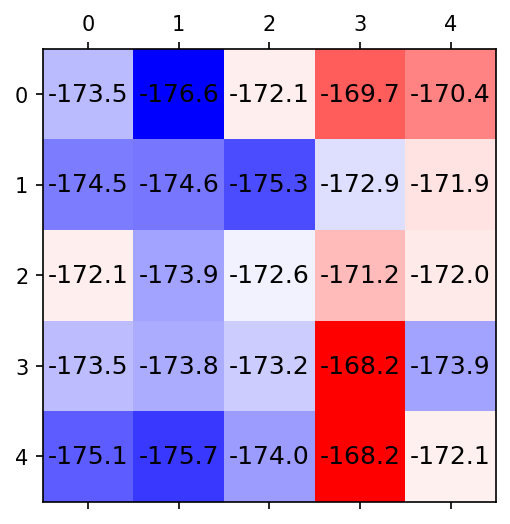

In [26]:
import matplotlib.pyplot as plt
plot_value_matrix(V)

In [ ]:
images_next

In [6]:
output = sr_network(images_next, Q_only = True)

In [8]:
output.Q.shape

torch.Size([64, 6])